In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def make_code(USAF, WBAN):
    return str(USAF) + str(int(WBAN)).zfill(5)

## 데이터 처리

TIME과 TIME_OF_DAY
* TIME이 NA지만 TIME_OF_DAY가 NA가 아닌 것
    - 중에서 SKY와 PRECIPITATION이 **모두 NA가 아닌 것들**만 사용 가능.
    - 둘 중 하나라도 NA인 것들은 제거

1. TIME_OF_DAY 만 있는 것
2. 중에서 SKY와 PRECIPITATION이 모두 NA가 아닌 것

In [4]:
data = pd.read_csv('/content/drive/MyDrive/DM/data/filtered2_with_index.csv')
isd = pd.read_csv('/content/drive/MyDrive/DM/data/isd-history.csv')

In [5]:
cols_in_data = data.columns

In [ ]:
isd[isd['USAF'] == '726070']

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
20472,726070,14606,BANGOR INTERNATIONAL ARPT,US,ME,KBGR,44.798,-68.819,44.9,20100801,20250421
20473,726070,99999,BANGOR INTL,US,ME,KBGR,44.800,-68.817,60.0,19730101,20100731


### NA IMPUTATION

In [6]:
def weather_processing(data, isd):


    # 관측 시작 - 끝 시점 날짜 형식으로 변경
    isd['BEGIN'] = pd.to_datetime(isd['BEGIN'], format='%Y%m%d')
    isd['END'] = pd.to_datetime(isd['END'], format='%Y%m%d')

    # # 우선 결측치를 채워야 하는 것 => SKY나 PRECIPITATION이 NA인 것만 필터링
    # data = data[(data['SKY'].isna()) | (data['PRECIPITATION'].isna())]

    # 시간이 결측치가 아닌 것만 필터링
    data = data[~data['TIME'].isna()]

    # data의 날짜도 => time까지 붙여서 새로 만들기
    data['DATETIME'] = pd.to_datetime(data['INCIDENT_DATE'] + ' ' + data['TIME'])
    data['INCIDENT_DATE'] = pd.to_datetime(data['INCIDENT_DATE'])


    # isd와 left join
    data = pd.merge(data, isd[['USAF', 'WBAN', 'ICAO', 'BEGIN', 'END']], how='left', left_on='AIRPORT_ID', right_on='ICAO').drop(columns='ICAO')

    # INCIDENT_DATE가 BEGIN ~ END 사이에 있는 경우만 남김
    data = data[(data['INCIDENT_DATE'] >= data['BEGIN']) & (data['INCIDENT_DATE'] <= data['END'])]

    # 중복 제거
    data = data[~data.iloc[:,:-4].duplicated(keep='first')]

    return data



In [7]:
# 시간이 있는 데이터만 분리
weather_na = weather_processing(data, isd)
weather_na

,index,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,DATETIME,USAF,WBAN,BEGIN,END
0,0,1990-08-07,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,1,Large,NaN,NaN,NaN,1990-08-07 20:25:00,724340,13994.0,1973-01-01,2025-04-21
2,6,1990-08-05,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.1754,-76.66820,...,2-10,Small,NaN,NaN,NaN,1990-08-05 19:05:00,724060,93721.0,1945-01-01,2025-04-21
4,10,1990-10-31,10,1990,08:08,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.6925,-74.16866,...,1,Medium,NaN,NaN,NaN,1990-10-31 08:08:00,725020,14734.0,1973-01-01,2025-04-21
6,15,1991-04-17,4,1991,13:15,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,1,Medium,NaN,NaN,NaN,1991-04-17 13:15:00,724050,13743.0,1936-09-01,2025-04-21
9,17,1990-10-15,10,1990,10:07,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,1,Medium,NaN,NaN,NaN,1990-10-15 10:07:00,723183,13877.0,1990-02-28,1997-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275096,135912,2024-12-06,12,2024,18:30,Night,KOGD,OGDEN-HINCKLEY ARPT,41.19594,-112.01218,...,1,NaN,NaN,NaN,NaN,2024-12-06 18:30:00,725750,24126.0,1973-01-01,2025-04-21
275099,135913,2024-09-26,9,2024,21:16,NaN,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,...,1,NaN,NaN,NaN,NaN,2024-09-26 21:16:00,722310,12916.0,1945-10-01,2025-04-21
275100,135914,2024-11-30,11,2024,09:35,Day,KEWB,NEW BEDFORD REGIONAL ARPT,41.67614,-70.95694,...,1,Medium,NaN,NaN,NaN,2024-11-30 09:35:00,725065,94726.0,2006-01-01,2025-04-21
275102,135915,2024-12-04,12,2024,23:26,Night,KSGR,SUGAR LAND REGIONAL ARPT,29.62225,-95.65653,...,1,Small,NaN,NaN,NaN,2024-12-04 23:26:00,722543,12977.0,2006-01-01,2025-04-21


In [8]:
station = pd.read_csv("/content/drive/MyDrive/DM/data/weather_result.csv")
station = station.set_index('Unnamed: 0').rename_axis(None)
station

,DATE,WND,CIG,VIS,TMP,DEW,SLP,AA1,AT1,AU1,GD1,OC1
0,1990-08-07 20:00:00,"100,5,N,0036,5","09144,5,9,N","032000,5,N,1","+0239,5","+0100,5","10232,5","01,0000,9,5",NaN,NaN,"2,03,5,+01500,9,9",NaN
2,1990-08-05 19:00:00,"180,5,N,0046,5","01524,5,9,N","008000,5,N,1","+0261,5","+0228,5","10161,5","01,0000,9,5",NaN,NaN,"2,02,5,+00750,9,9",NaN
4,1990-10-31 08:00:00,"250,5,N,0036,5","01829,5,M,N","019200,5,N,1","+0100,5","+0017,5","10202,5","01,0000,9,5",NaN,NaN,"3,05,5,+01800,9,9",NaN
6,1991-04-17 13:00:00,"170,1,N,0046,1","22000,1,9,N","024000,1,N,1","+0161,1","+0122,1","10159,1","01,0000,9,5",NaN,NaN,"2,99,1,+03900,1,9",NaN
12,1990-09-21 13:00:00,"999,1,C,0000,1","22000,1,9,N","048000,1,N,1","+0100,1","+0000,1","99999,9",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
275096,2024-12-06 18:53:00,"310,5,N,0015,5","22000,5,9,N","011265,5,N,5","+0039,5","-0022,5","10298,5","01,0000,9,5",NaN,NaN,"0,99,1,+99999,9,9",NaN
275099,2024-09-26 21:00:00,"350,1,N,0077,1","22000,1,9,N","016000,1,9,9","+0300,1","+0167,1","10034,1",NaN,NaN,NaN,NaN,NaN
275100,2024-11-30 09:53:00,"280,5,N,0051,5","22000,5,9,N","016093,5,N,5","+0006,5","-0044,5","10111,5","01,0000,9,5",NaN,NaN,"0,99,1,+99999,9,9",NaN
275102,2024-12-04 23:31:00,"210,1,N,0031,1","00945,1,9,N","014484,1,9,9","+0222,1","+0206,1","99999,9","01,0002,3,1",NaN,NaN,"1,99,1,+00701,1,9",NaN


In [9]:
weather_na = weather_na.join(station)
weather_na

,index,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,CIG,VIS,TMP,DEW,SLP,AA1,AT1,AU1,GD1,OC1
0,0,1990-08-07,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,"09144,5,9,N","032000,5,N,1","+0239,5","+0100,5","10232,5","01,0000,9,5",NaN,NaN,"2,03,5,+01500,9,9",NaN
2,6,1990-08-05,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.1754,-76.66820,...,"01524,5,9,N","008000,5,N,1","+0261,5","+0228,5","10161,5","01,0000,9,5",NaN,NaN,"2,02,5,+00750,9,9",NaN
4,10,1990-10-31,10,1990,08:08,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.6925,-74.16866,...,"01829,5,M,N","019200,5,N,1","+0100,5","+0017,5","10202,5","01,0000,9,5",NaN,NaN,"3,05,5,+01800,9,9",NaN
6,15,1991-04-17,4,1991,13:15,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,"22000,1,9,N","024000,1,N,1","+0161,1","+0122,1","10159,1","01,0000,9,5",NaN,NaN,"2,99,1,+03900,1,9",NaN
9,17,1990-10-15,10,1990,10:07,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275096,135912,2024-12-06,12,2024,18:30,Night,KOGD,OGDEN-HINCKLEY ARPT,41.19594,-112.01218,...,"22000,5,9,N","011265,5,N,5","+0039,5","-0022,5","10298,5","01,0000,9,5",NaN,NaN,"0,99,1,+99999,9,9",NaN
275099,135913,2024-09-26,9,2024,21:16,NaN,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,...,"22000,1,9,N","016000,1,9,9","+0300,1","+0167,1","10034,1",NaN,NaN,NaN,NaN,NaN
275100,135914,2024-11-30,11,2024,09:35,Day,KEWB,NEW BEDFORD REGIONAL ARPT,41.67614,-70.95694,...,"22000,5,9,N","016093,5,N,5","+0006,5","-0044,5","10111,5","01,0000,9,5",NaN,NaN,"0,99,1,+99999,9,9",NaN
275102,135915,2024-12-04,12,2024,23:26,Night,KSGR,SUGAR LAND REGIONAL ARPT,29.62225,-95.65653,...,"00945,1,9,N","014484,1,9,9","+0222,1","+0206,1","99999,9","01,0002,3,1",NaN,NaN,"1,99,1,+00701,1,9",NaN


#### SKY, PRECIPITATION IMPUTATION

##### PRECIPITATION

In [10]:
def col_split(df, col_name):
    df_split = df[col_name].str.split(',', expand=True)
    df_split.columns = [f'{col_name}_{i+1}' for i in range(df_split.shape[1])]

    df = pd.concat([df, df_split], axis=1).drop(columns=col_name)

    return df

In [11]:
prec = weather_na[['PRECIPITATION', 'AA1', 'AT1', 'AU1']]
prec['PRECIPITATION'] = prec['PRECIPITATION'].fillna("Unknown")

In [12]:
print(prec['PRECIPITATION'].value_counts(dropna=False))

PRECIPITATION
Unknown            122526
Rain                 5678
Fog                  1453
Snow                  392
Fog, Rain             257
Rain, Snow             25
Fog, Snow              14
None, Rain              8
Fog, Rain, Snow         6
None, Snow              5
Fog, None               1
Name: count, dtype: int64


In [13]:
prec_split = prec.copy()
for col in prec.columns.tolist()[1:]:
    prec_split = col_split(prec_split, col)

prec_split['AA1_2'] = prec_split['AA1_2'].apply(lambda x: int(x) if pd.notna(x) else x)

1. AT1이 기록된 것
    - RA(16) => rain
    - TS(03) => Thunder
    - BR(13) => Mist
    - FG(01) => Fog
    - HZ(08) => Smoke or haze
    - DZ(14) => Drizzle
    - SN(18) => SNOW
    - MIFG(21) => Ground Fog
2. AU1이 기록된 것  
    * AU1_3 (precipitation code)가 0(Np precipitation)일 때에만 AU1_4 (obscuration)이 존재  
    a) AU1_3이  
        - 01: DZ, Drizzle
        - 02: RA, Rain
        - 03: SN, Snow
        - 06: PL, Ice Pellets
        - 09: Unknown  
          
    b) AU1_4
        - 0: No
        - 1: Mist
        - 2: Fog
        - 3: Smoke
        - ... 어쨌든 전부 Fog종류들임

3. 둘 다 없는 것
    - AA1_2가 0이면 비x, 아니면 Rain으로 기록.

In [14]:
def impute_prec(row):

    if row['PRECIPITATION'] == 'Unknown':      # PRECIPITATION이 unknown인 경우에

        if pd.notna(row['AT1_3']):

            row['AT1_3'] = row['AT1_3'].strip()     # 글자 뒤 공백 제거

            if row['AT1_3'] == 'RA' or row['AT1_3'] == 'TS' or row['AT1_3'] == 'DZ':
                row['PRECIPITATION'] = 'Rain'
            elif row['AT1_3'] == 'SN':
                row['PRECIPITATION'] = 'Snow'
            elif row['AT1_3'] == 'BR' or row['AT1_3'] == 'FG' or row['AT1_3'] == 'HZ' or row['AT1_3'] == 'MIFG':
                row['PRECIPITATION'] = 'Fog'


        elif pd.notna(row['AU1_3']):
            if row['AU1_3'] == '01' or row['AU1_3'] == '02':     # drizzle or rain
                row['PRECIPITATION'] = 'Rain'
            elif row['AU1_3'] == '03' or row['AU1_3'] == '06':
                row['PRECIPITATION'] = 'Snow'

            elif row['AU1_3'] == '00':
                if row['AU1_4'] == '0':
                    row['PRECIPITATION'] = 'Rain'
                else:
                    row['PRECIPITATION'] = 'Fog'


        elif row['AA1_2'] > 0 :
            row['PRECIPITATION'] = 'Rain'

        elif row['AA1_2'] == 0:
            row['PRECIPITATION'] = 'N'

    return row

In [15]:
prec_split = prec_split.apply(impute_prec, axis=1)
print(prec_split['PRECIPITATION'].value_counts(dropna=False))

PRECIPITATION
N                  88043
Unknown            22487
Rain               12900
Fog                 5862
Snow                 757
Fog, Rain            257
Rain, Snow            25
Fog, Snow             14
None, Rain             8
Fog, Rain, Snow        6
None, Snow             5
Fog, None              1
Name: count, dtype: int64


In [16]:
## Snow -> Rain -> Fog 순서로

prec_split['PRECIPITATION'] = prec_split['PRECIPITATION'].replace({
    'Fog, Rain': 'Rain',
    'Rain, Snow': 'Snow',
    'Fog, Snow': 'Snow',
    'None, Rain': 'Rain',
    'Fog, Rain, Snow': 'Snow',
    'None, Snow': 'Snow',
    'Fog, None': 'Fog'
})

In [17]:
# 최종
print(prec_split['PRECIPITATION'].value_counts(dropna=False))

PRECIPITATION
N          88043
Unknown    22487
Rain       13165
Fog         5863
Snow         807
Name: count, dtype: int64


In [18]:
# weather_na에 결합
weather_na = weather_na.drop(columns='PRECIPITATION').join(prec_split['PRECIPITATION'])

In [19]:
weather_na['PRECIPITATION'].isna().sum()

np.int64(0)

##### SKY

In [20]:
cloud = weather_na[['SKY', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'GD1', 'PRECIPITATION']]

<Axes: xlabel='GD1_1'>

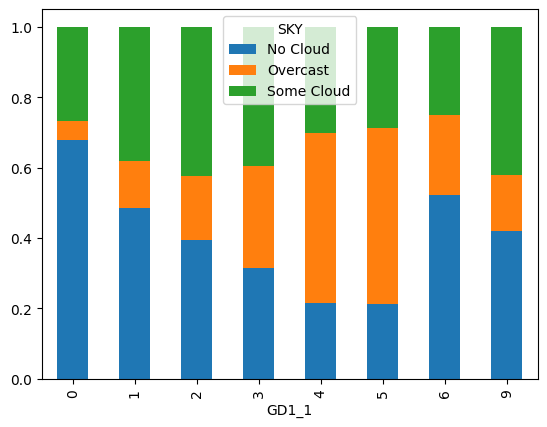

In [21]:
gd_split = col_split(cloud, 'GD1')
grouped = gd_split.groupby(['GD1_1', 'SKY']).size().unstack(fill_value=0)
grouped.div(grouped.sum(axis=1), axis=0).plot(kind='bar', stacked=True)

0, 1, 6 => No Cloud  (No coverage ~ 2/8 or less coverage)  
2, 3 => Some Cloud  
4, 5 => Overcast



###### 구름량 결측치 제거 후 예측

In [22]:
split = cloud.copy()
cols_to_split = split.columns.tolist()[1:-1]
# 각 컬럼에 대해 col_split 적용
for col in cols_to_split:
    split = col_split(split, col)

# 쓸 컬럼만 선택
split = split[['SKY', 'WND_1', 'WND_4', 'CIG_1', 'VIS_1', 'TMP_1', 'DEW_1', 'SLP_1', 'GD1_1', 'GD1_4', 'PRECIPITATION']]

# 강수량 더미코딩
split = pd.get_dummies(split, columns=['PRECIPITATION'], drop_first=True)

# print(split.isna().sum())

# # 결측치 있는 부분 제거 후 int형으로
# split = split.query('AA1_2.notnull()')
# 결측치는 내버려 두고 나머지를 int형으로
split.iloc[:, 1:-1] = split.iloc[:, 1:-1].applymap(lambda x: int(x) if pd.notna(x) else x)

# 컬럼별 999 를 결측치로
missing_code = {
    'WND_1': 999,
    'WND_4': 9999,
    'CIG_1': 99999,
    'VIS_1': 999999,
    'TMP_1': 9999,
    'DEW_1': 9999,
    'SLP_1': 99999,
    'GD1_1': 9,
    'GD1_4': 99999
}

for col, values in missing_code.items():
    split[col] = split[col].replace(values, np.nan)


# 최종 결측치 개수
print(split.isna().sum())

# 999였던 결측치 부분 다시 제거
# split = split.dropna()

# 구름량 예측에 쓸 최종 데이터셋
print(split)

SKY                      29620
WND_1                    27108
WND_4                     6061
CIG_1                    12443
VIS_1                     5881
TMP_1                     5980
DEW_1                     6101
SLP_1                    19624
GD1_1                    25810
GD1_4                    44884
PRECIPITATION_N              0
PRECIPITATION_Rain           0
PRECIPITATION_Snow           0
PRECIPITATION_Unknown        0
dtype: int64
               SKY  WND_1  WND_4    CIG_1    VIS_1  TMP_1  DEW_1    SLP_1  \
0         No Cloud  100.0   36.0   9144.0  32000.0  239.0  100.0  10232.0   
2       Some Cloud  180.0   46.0   1524.0   8000.0  261.0  228.0  10161.0   
4         No Cloud  250.0   36.0   1829.0  19200.0  100.0   17.0  10202.0   
6         No Cloud  170.0   46.0  22000.0  24000.0  161.0  122.0  10159.0   
9         No Cloud    NaN    NaN      NaN      NaN    NaN    NaN      NaN   
...            ...    ...    ...      ...      ...    ...    ...      ...   
275096    No C

In [23]:
# 바람 방향 사인/코사인 변환
split['WND_1_sin'] = np.sin(np.radians(split['WND_1']))
split['WND_1_cos'] = np.cos(np.radians(split['WND_1']))
split = split.drop(columns='WND_1')

In [24]:
print(split)

               SKY  WND_4    CIG_1    VIS_1  TMP_1  DEW_1    SLP_1  GD1_1  \
0         No Cloud   36.0   9144.0  32000.0  239.0  100.0  10232.0    2.0   
2       Some Cloud   46.0   1524.0   8000.0  261.0  228.0  10161.0    2.0   
4         No Cloud   36.0   1829.0  19200.0  100.0   17.0  10202.0    3.0   
6         No Cloud   46.0  22000.0  24000.0  161.0  122.0  10159.0    2.0   
9         No Cloud    NaN      NaN      NaN    NaN    NaN      NaN    NaN   
...            ...    ...      ...      ...    ...    ...      ...    ...   
275096    No Cloud   15.0  22000.0  11265.0   39.0  -22.0  10298.0    0.0   
275099         NaN   77.0  22000.0  16000.0  300.0  167.0  10034.0    NaN   
275100    No Cloud   51.0  22000.0  16093.0    6.0  -44.0  10111.0    0.0   
275102         NaN   31.0    945.0  14484.0  222.0  206.0      NaN    1.0   
275104  Some Cloud    0.0  22000.0  16093.0  122.0  -22.0  10141.0    0.0   

         GD1_4  PRECIPITATION_N  PRECIPITATION_Rain  PRECIPITATION_Snow  \


###### 모델

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


sky_filtered = split.query('SKY.notnull()')

le = LabelEncoder()
y_encoded = le.fit_transform(sky_filtered['SKY'])  # 0: No Cloud, 1: Overcast, 2: Some Cloud


X_train, X_valid, y_train, y_valid = train_test_split(sky_filtered.iloc[:,1:],
                                                      y_encoded,
                                                      test_size = 0.2,
                                                      random_state=42,
                                                      stratify=y_encoded)

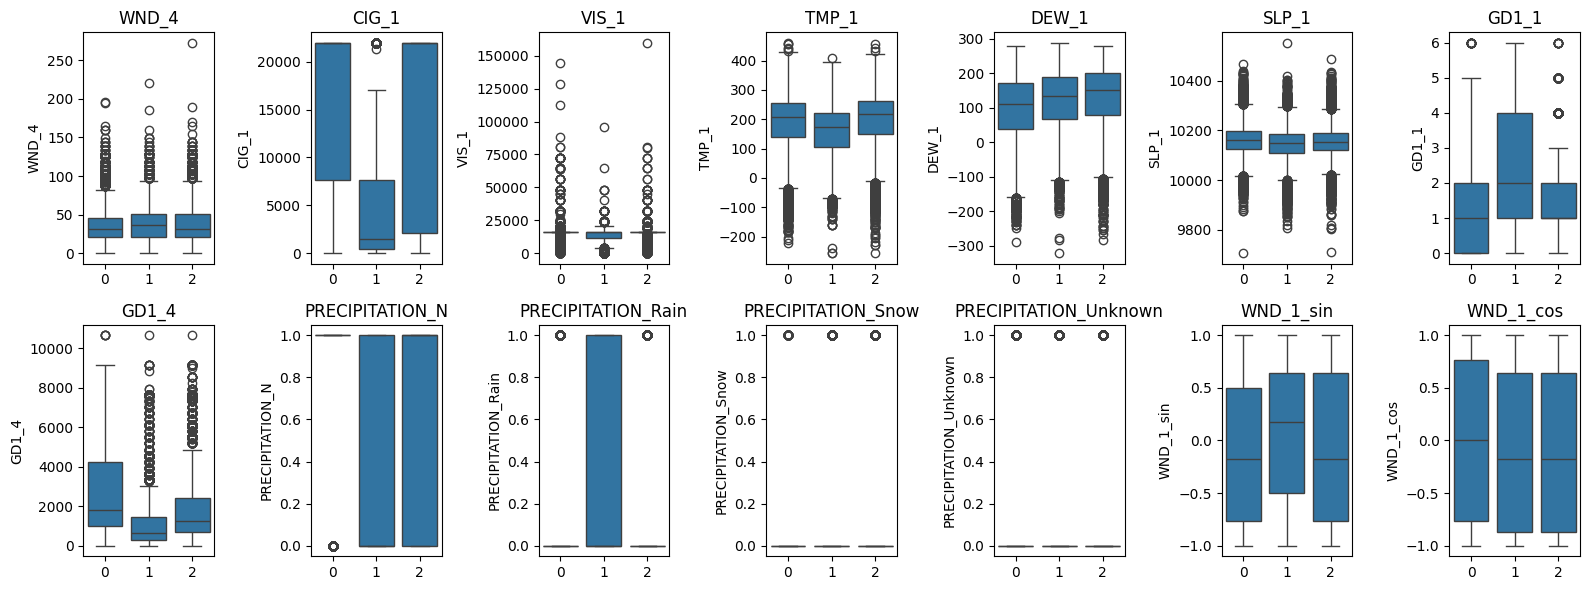

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 7, figsize=(16, 6))
axes = axes.flatten()
for idx, col in enumerate(X_train.columns):
    sns.boxplot(x=y_train, y=X_train[col], ax=axes[idx])
    axes[idx].set_title(f"{col}")

plt.tight_layout()
plt.show()

In [27]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.1 MB/s eta 0:00:00


In [28]:
# NA를 포함해서 분류하기 위해 XGBoost, LGBM, CatBoost 사용.. => Soft Voting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


xgb_model = XGBClassifier(learning_rate=0.1, verbose=0)
lgb_model = LGBMClassifier(learning_rate=0.1, verbose=-1)
cat_model = CatBoostClassifier(learning_rate=0.1, verbose=0)

soft_model = VotingClassifier(
    estimators = [
        ('xgb', xgb_model),
        ('lgbm', lgb_model),
        ('cat', cat_model)
    ],
    voting="soft"
)

#### fitting ####
soft_model.fit(X_train, y_train)
soft_pred = soft_model.predict(X_valid)

print("##### Soft Voting result #####")
print(confusion_matrix(y_valid, soft_pred))
print(classification_report(y_valid, soft_pred))
print(accuracy_score(y_valid, soft_pred))

##### Soft Voting result #####
[[7486  407 1751]
 [ 707 1709 1018]
 [3597  862 2612]]
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      9644
           1       0.57      0.50      0.53      3434
           2       0.49      0.37      0.42      7071

    accuracy                           0.59     20149
   macro avg       0.56      0.55      0.55     20149
weighted avg       0.57      0.59      0.57     20149

0.5859844161000546


In [29]:
# fitting한 앙상블 모델로 SKY 결측치 채워넣기

X_test = split.query('~SKY.notnull()').iloc[:,1:]
sky_pred = soft_model.predict(X_test)

sky_pred = le.inverse_transform(sky_pred)

In [30]:
null_sky = split.query('~SKY.notnull()')
null_sky['SKY'] = sky_pred

In [31]:
print(null_sky['SKY'])

14          No Cloud
20          No Cloud
45        Some Cloud
105         Overcast
115       Some Cloud
             ...    
275084    Some Cloud
275088      Overcast
275092      No Cloud
275099      No Cloud
275102      Overcast
Name: SKY, Length: 29620, dtype: object


In [32]:
# weather_na에 결합

mask = weather_na['SKY'].isna()
weather_na.loc[mask, 'SKY'] = null_sky.loc[mask]

#### 최종 결합하기

In [33]:
print(weather_na[cols_in_data][['SKY','PRECIPITATION']].isna().sum())

SKY              0
PRECIPITATION    0
dtype: int64


In [34]:
weather_na_final = weather_na[['index', 'SKY', 'PRECIPITATION']]
weather_na_final = weather_na_final.set_index('index')
weather_na_final.index.name = None

In [35]:
data_filled = data.copy()
data_filled.loc[weather_na_final.index, ['SKY', 'PRECIPITATION']] = weather_na_final
data_filled = data_filled.drop(columns='index')

In [36]:
data_filled

,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,STATE,...,SPECIES,OUT_OF_RANGE_SPECIES,REMARKS,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES
0,1990-08-07,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,MO,...,unknown bird - large,0,LANDING LIGHT KNOCKED OUT. TOOK EVASIVE ACTION...,No,1,1,Large,NaN,NaN,NaN
1,1990-09-07,9,1990,NaN,Day,KAGS,AUGUSTA REGIONAL ARPT AT BUSH FLD,33.36996,-81.96450,GA,...,unknown bird - small,0,NO DAMAGE. VIZ 3 FOG HAZE,No,2-10,2-10,Small,NaN,NaN,NaN
2,1993-12-08,12,1993,NaN,Day,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.03720,TX,...,unknown bird - small,0,NO APPARENT DAMAGE.,No,1,1,Small,NaN,NaN,NaN
3,1994-09-01,9,1994,NaN,Dawn,KSYR,SYRACUSE HANCOCK INTL,43.11119,-76.10631,NY,...,gulls,0,NaN,Yes,2-10,1,Medium,NaN,NaN,NaN
4,1990-05-25,5,1990,NaN,Day,KMDW,CHICAGO MIDWAY INTL ARPT,41.78598,-87.75242,IL,...,gulls,0,NO DAMAGE. FLT 773.,No,NaN,1,Medium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135912,2024-12-06,12,2024,18:30,Night,KOGD,OGDEN-HINCKLEY ARPT,41.19594,-112.01218,UT,...,unknown bird,0,No damages to the aircraft are visible. left e...,No,NaN,1,NaN,NaN,NaN,NaN
135913,2024-09-26,9,2024,21:16,NaN,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,LA,...,unknown bird,0,"At 0216z, JIA5580 reported a bird strike at 30...",Unknown,NaN,1,NaN,NaN,NaN,NaN
135914,2024-11-30,11,2024,09:35,Day,KEWB,NEW BEDFORD REGIONAL ARPT,41.67614,-70.95694,MA,...,herring gull,0,Airport Operations responded to a reported bir...,Unknown,NaN,1,Medium,NaN,NaN,NaN
135915,2024-12-04,12,2024,23:26,Night,KSGR,SUGAR LAND REGIONAL ARPT,29.62225,-95.65653,TX,...,killdeer,0,AEROSTAR TRANSPORTATION SYSTEMS LLC. one photo,Unknown,NaN,1,Small,NaN,NaN,NaN


In [37]:
print(data_filled[['SKY', 'PRECIPITATION']].isna().sum())
# 데이터 못 받은 곳으로 예상됨 => 관측소에서 제공하는 time range에 사고 발생 기간이 포함되지 않는 것들

SKY               223
PRECIPITATION    2604
dtype: int64


##### 여전히 NA인 곳은 뭐지?

In [ ]:
still_missing = data_filled[data_filled['SKY'].isnull() | data_filled['PRECIPITATION'].isnull()].index
len(still_missing)

2606

In [ ]:
    # 관측 시작 - 끝 시점 날짜 형식으로 변경
    isd['BEGIN'] = pd.to_datetime(isd['BEGIN'], format='%Y%m%d')
    isd['END'] = pd.to_datetime(isd['END'], format='%Y%m%d')

    # # 우선 결측치를 채워야 하는 것 => SKY나 PRECIPITATION이 NA인 것만 필터링
    # data = data[(data['SKY'].isna()) | (data['PRECIPITATION'].isna())]

    # 시간이 결측치가 아닌 것만 필터링
    data = data[~data['TIME'].isna()]

    # data의 날짜도 => time까지 붙여서 새로 만들기
    data['DATETIME'] = pd.to_datetime(data['INCIDENT_DATE'] + ' ' + data['TIME'])
    data['INCIDENT_DATE'] = pd.to_datetime(data['INCIDENT_DATE'])


    # isd와 left join
    data = pd.merge(data, isd[['USAF', 'WBAN', 'ICAO', 'BEGIN', 'END']], how='left', left_on='AIRPORT_ID', right_on='ICAO').drop(columns='ICAO')

    # INCIDENT_DATE가 BEGIN ~ END 사이에 있는 경우만 남김
    data = data[(data['INCIDENT_DATE'] >= data['BEGIN']) & (data['INCIDENT_DATE'] <= data['END'])]

    # 중복 제거
    data = data[~data.iloc[:,:-4].duplicated(keep='first')]


In [ ]:
data_check = data.copy()
isd_check = isd.copy()

isd_check['BEGIN'] = pd.to_datetime(isd_check['BEGIN'], format='%Y%m%d')
isd_check['END'] = pd.to_datetime(isd_check['END'], format='%Y%m%d')
data_check = data_check.query('TIME.notnull()')
data_check['DATETIME'] = pd.to_datetime(data_check['INCIDENT_DATE'] + ' ' + data_check['TIME'])
data_check['INCIDENT_DATE'] = pd.to_datetime(data_check['INCIDENT_DATE'])

check = pd.merge(data_check, isd_check[['USAF', 'WBAN', 'ICAO', 'BEGIN', 'END']], how='left', left_on='AIRPORT_ID', right_on='ICAO').drop(columns='ICAO')
check

,index,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,DATETIME,USAF,WBAN,BEGIN,END
0,0,1990-08-07,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,1,Large,NaN,NaN,NaN,1990-08-07 20:25:00,724340,13994.0,1973-01-01,2025-04-21
1,0,1990-08-07,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,1,Large,NaN,NaN,NaN,1990-08-07 20:25:00,999999,13994.0,1945-01-01,1972-12-31
2,6,1990-08-05,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.1754,-76.66820,...,2-10,Small,NaN,NaN,NaN,1990-08-05 19:05:00,724060,93721.0,1945-01-01,2025-04-21
3,6,1990-08-05,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.1754,-76.66820,...,2-10,Small,NaN,NaN,NaN,1990-08-05 19:05:00,999999,93721.0,1965-01-01,1972-12-31
4,10,1990-10-31,10,1990,08:08,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.6925,-74.16866,...,1,Medium,NaN,NaN,NaN,1990-10-31 08:08:00,725020,14734.0,1973-01-01,2025-04-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275102,135915,2024-12-04,12,2024,23:26,Night,KSGR,SUGAR LAND REGIONAL ARPT,29.62225,-95.65653,...,1,Small,NaN,NaN,NaN,2024-12-04 23:26:00,722543,12977.0,2006-01-01,2025-04-21
275103,135915,2024-12-04,12,2024,23:26,Night,KSGR,SUGAR LAND REGIONAL ARPT,29.62225,-95.65653,...,1,Small,NaN,NaN,NaN,2024-12-04 23:26:00,722543,99999.0,1997-01-23,1997-12-31
275104,135916,2024-12-12,12,2024,18:06,Night,KBUR,BOB HOPE ARPT,34.20062,-118.35850,...,1,Small,NaN,NaN,NaN,2024-12-12 18:06:00,722880,23152.0,1943-06-01,2025-04-21
275105,135916,2024-12-12,12,2024,18:06,Night,KBUR,BOB HOPE ARPT,34.20062,-118.35850,...,1,Small,NaN,NaN,NaN,2024-12-12 18:06:00,722880,99999.0,2000-01-01,2003-12-31


In [ ]:
check2 = check.loc[check['index'].isin(still_missing)]
check2.query('BEGIN.notnull()')[['INCIDENT_DATE', 'BEGIN', 'END']]      # 해당 기간의 데이터가 없는 곳이었음.

,INCIDENT_DATE,BEGIN,END
59,1992-11-16,2006-01-01,2025-04-21
60,1992-11-16,1998-02-01,2005-12-31
538,1998-09-13,2000-01-01,2025-04-21
539,1998-09-13,1973-01-01,1997-12-31
570,1994-02-27,2006-01-01,2025-04-21
...,...,...,...
265840,2002-07-08,2005-01-01,2025-04-21
265841,2002-07-08,1948-01-01,1972-12-31
266726,2004-06-30,1973-01-01,1997-12-31
266727,2004-06-30,2005-01-01,2025-04-21


##### 파일로 저장

In [38]:
print(data_filled['DAMAGE_LEVEL'].value_counts())

DAMAGE_LEVEL
N     108715
M?      4585
M       3741
S       1777
D         18
Name: count, dtype: int64


In [39]:
print(data_filled['PRECIPITATION'].value_counts())

PRECIPITATION
N             88043
Unknown       22487
Rain          15004
Fog            6779
Snow            937
Fog, Rain        57
Fog, Snow         3
Rain, Snow        3
Name: count, dtype: int64


In [40]:
data_filled['PRECIPITATION'] = data_filled['PRECIPITATION'].replace({
    'Fog, Rain': 'Rain',
    'Rain, Snow': 'Snow',
    'Fog, Snow': 'Snow'
})

In [43]:
print(data_filled['SKY'].value_counts(dropna=False))
print(data_filled['PRECIPITATION'].value_counts(dropna=False))

SKY
No Cloud      67227
Some Cloud    45339
Overcast      23128
NaN             223
Name: count, dtype: int64
PRECIPITATION
N          88043
Unknown    22487
Rain       15061
Fog         6779
NaN         2604
Snow         943
Name: count, dtype: int64


precipitation의 unknown은 그냥 N으로 밀기  
sky의 NA도 가장 많이 나타나는 것으로 밀기

In [44]:
data_filled = data_filled.fillna({
    'SKY': 'No Cloud',
    'PRECIPITATION': 'N'})
data_filled['PRECIPITATION'] = data_filled['PRECIPITATION'].replace("Unknown", "N")

In [46]:
print(data_filled['SKY'].value_counts(dropna=False))
print(data_filled['PRECIPITATION'].value_counts(dropna=False))

SKY
No Cloud      67450
Some Cloud    45339
Overcast      23128
Name: count, dtype: int64
PRECIPITATION
N       113134
Rain     15061
Fog       6779
Snow       943
Name: count, dtype: int64


In [47]:
# 파일로 저장
data_filled.to_csv("/content/drive/MyDrive/DM/data/data_filled.csv", index=False)